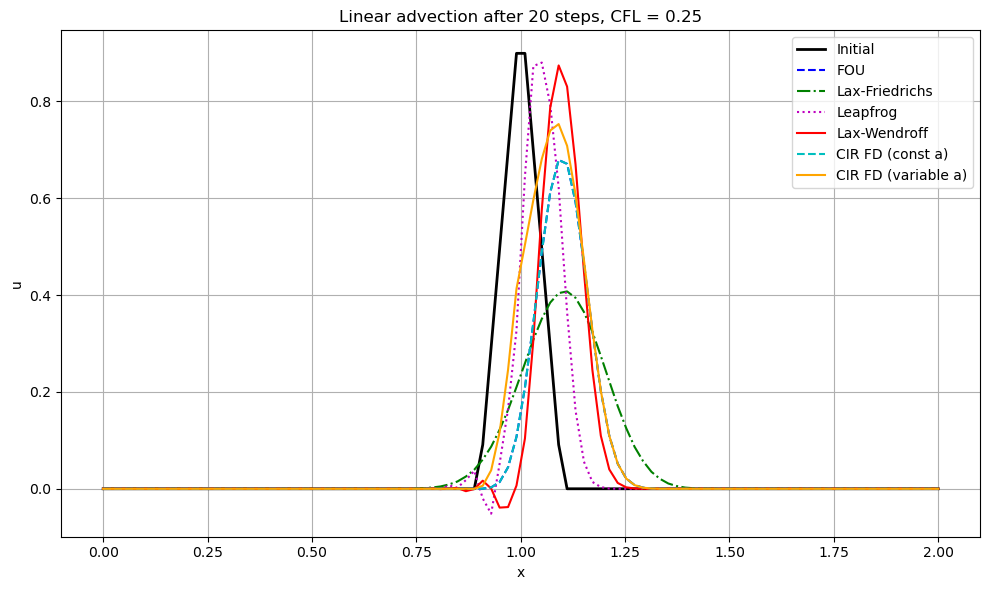


Error norms relative to exact shifted pulse
Scheme                    L1           L2         Linf
FOU                1.348e-02    4.223e-02    2.282e-01
Lax-Friedrichs     3.752e-02    9.913e-02    4.950e-01
Leapfrog           4.447e-02    1.367e-01    5.797e-01
Lax-Wendroff       5.965e-03    1.761e-02    9.005e-02
CIR FD             1.348e-02    4.223e-02    2.282e-01


In [5]:
import numpy as np
import matplotlib.pyplot as plt


def main():
    # Grid and run parameters
    x_min, x_max = 0.0, 2.0
    nx = 100
    x = np.linspace(x_min, x_max, nx)
    dx = (x_max - x_min) / (nx - 1)
    CFL = 0.25
    nt = 20

    # Constant-speed case
    a_const = 1.0
    dt_const = CFL * dx / a_const

    # Variable-speed case
    def a_func(xx):
        return np.where(xx < 1.0, 1.0, 2.0)

    a_field = a_func(x)
    dt_var = CFL * dx / np.max(np.abs(a_field))

    # Initial triangular pulse
    u_initial = initial_pulse(x)

    # Run all schemes
    u_fou = fou_scheme(u_initial, nt, dt_const, dx, a_const)
    u_lf = lax_friedrichs(u_initial, nt, dt_const, dx, a_const)
    u_leapfrog = leapfrog(u_initial, nt, dt_const, dx, a_const)
    u_lw = lax_wendroff(u_initial, nt, dt_const, dx, a_const)
    u_cir = cir_fd_scheme(u_initial, nt, dt_const, dx, a_const)
    u_cir_var = cir_fd_variable_a(u_initial, a_field, nt, dt_var, dx)

    # Plot results
    plot_results(x, u_initial, u_fou, u_lf, u_leapfrog, u_lw, u_cir, u_cir_var, nt, CFL)

    # Calculate and print error norms
    print_error_norms(u_initial, u_fou, u_lf, u_leapfrog, u_lw, u_cir, a_const, nt, dt_const, dx)


def initial_pulse(xx):
    """Create initial triangular pulse."""
    u = np.zeros_like(xx)
    mask1 = (xx >= 0.9) & (xx <= 1.0)
    mask2 = (xx >= 1.0) & (xx <= 1.1)
    u[mask1] = 10.0 * (xx[mask1] - 0.9)
    u[mask2] = 10.0 * (1.1 - xx[mask2])
    return u


def fou_scheme(u, nt, dt, dx, a):
    """First-order upwind scheme."""
    u = u.copy()
    for _ in range(nt):
        u[1:] = u[1:] - (a * dt / dx) * (u[1:] - u[:-1])
        u[0] = u[-1]  # Periodic boundary condition
    return u


def lax_friedrichs(u, nt, dt, dx, a):
    """Lax-Friedrichs scheme."""
    u = u.copy()
    for _ in range(nt):
        u[1:-1] = 0.5 * (u[2:] + u[:-2]) - (a * dt / (2 * dx)) * (u[2:] - u[:-2])
        # Periodic boundary conditions
        u[0] = u[-2]
        u[-1] = u[1]
    return u


def leapfrog(u, nt, dt, dx, a):
    """Leapfrog scheme."""
    u_prev = u.copy()
    u_curr = u_prev - (a * dt / dx) * (np.roll(u_prev, -1) - u_prev)
    
    for _ in range(1, nt):
        u_next = u_prev - (a * dt / dx) * (np.roll(u_curr, -1) - np.roll(u_curr, 1)) / 2.0
        u_prev, u_curr = u_curr, u_next
    
    return u_curr


def lax_wendroff(u, nt, dt, dx, a):
    """Lax-Wendroff scheme."""
    u = u.copy()
    sigma = a * dt / dx
    
    for _ in range(nt):
        u[1:-1] = (
            u[1:-1] 
            - 0.5 * sigma * (u[2:] - u[:-2]) 
            + 0.5 * sigma**2 * (u[2:] - 2.0 * u[1:-1] + u[:-2])
        )
        # Periodic boundary conditions
        u[0] = u[-2]
        u[-1] = u[1]
    
    return u


def cir_fd_scheme(u, nt, dt, dx, a):
    """Courant-Isaacson-Rees finite-difference scheme."""
    lam = a * dt / dx
    u = u.copy()
    nx = len(u)
    
    for _ in range(nt):
        u_new = u.copy()
        for i in range(nx):
            im = (i - 1) % nx
            ip = (i + 1) % nx
            
            if lam > 0.0:
                u_new[i] = u[i] - lam * (u[i] - u[im])
            elif lam < 0.0:
                u_new[i] = u[i] - lam * (u[ip] - u[i])
            # lam == 0 leaves u_new[i] unchanged
        
        u = u_new
    
    return u


def cir_fd_variable_a(u, a_field, nt, dt, dx):
    """CIR scheme with variable wave speed."""
    u = u.copy()
    nx = len(u)
    
    for _ in range(nt):
        u_new = u.copy()
        for i in range(nx):
            im = (i - 1) % nx
            ip = (i + 1) % nx
            lam_i = a_field[i] * dt / dx
            
            if lam_i > 0.0:
                u_new[i] = u[i] - lam_i * (u[i] - u[im])
            elif lam_i < 0.0:
                u_new[i] = u[i] - lam_i * (u[ip] - u[i])
        
        u = u_new
    
    return u


def plot_results(x, u_initial, u_fou, u_lf, u_leapfrog, u_lw, u_cir, u_cir_var, nt, CFL):
    """Plot comparison of all schemes."""
    plt.figure(figsize=(10, 6))
    plt.plot(x, u_initial, 'k', linewidth=2, label='Initial')
    plt.plot(x, u_fou, 'b--', label='FOU')
    plt.plot(x, u_lf, 'g-.', label='Lax-Friedrichs')
    plt.plot(x, u_leapfrog, 'm:', label='Leapfrog')
    plt.plot(x, u_lw, 'r-', label='Lax-Wendroff')
    plt.plot(x, u_cir, 'c--', label='CIR FD (const a)')
    plt.plot(x, u_cir_var, 'orange', label='CIR FD (variable a)')
    
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(f'Linear advection after {nt} steps, CFL = {CFL}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('16P-13.png', dpi=300, format='png') 
    plt.show()


def print_error_norms(u_initial, u_fou, u_lf, u_leapfrog, u_lw, u_cir, a_const, nt, dt, dx):
    """Calculate and print error norms for each scheme."""
    shift_cells = int(a_const * nt * dt / dx + 0.5)
    u_exact = np.roll(u_initial, shift_cells)

    def error_norms(u_num, u_ref):
        L1 = np.mean(np.abs(u_num - u_ref))
        L2 = np.sqrt(np.mean((u_num - u_ref)**2))
        Linf = np.max(np.abs(u_num - u_ref))
        return L1, L2, Linf

    schemes = {
        'FOU': u_fou,
        'Lax-Friedrichs': u_lf,
        'Leapfrog': u_leapfrog,
        'Lax-Wendroff': u_lw,
        'CIR FD': u_cir
    }

    print('\nError norms relative to exact shifted pulse')
    print('{:<15s} {:>12s} {:>12s} {:>12s}'.format('Scheme', 'L1', 'L2', 'Linf'))
    
    for name, sol in schemes.items():
        L1, L2, Linf = error_norms(sol, u_exact)
        print('{:<15s} {:12.3e} {:12.3e} {:12.3e}'.format(name, L1, L2, Linf))


if __name__ == "__main__":
    main()